In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
from scipy.special import factorial
import h5py
import copy

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # changes per computer
#import magaoxFunctions as mf
import psd_functions as psd
import zernike as zern
import datafiles as dfx
import dust

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 14/05/2020 11:51:25


In [2]:
class dust:
    def __init__(self, name):
        self.name = name
        
    def set_mask(self, size, x_loc, y_loc, rad):
        self.size=size
        self.mask = [] # start off empty
        for nx in range(0, len(x_loc)):
            mask_step = np.ones((size, size)).astype(float)
            dmc = np.zeros((size, size))
            dm_coord = draw.circle(r=y_loc, c=x_loc[nx], radius=rad)
            dmc[dm_coord] = True
            mask_step[dmc==True] = np.nan
            self.mask.append(mask_step)
        self.n_steps = len(self.mask)
            
    def load_mask(self, mask_set):
        self.mask=[]
        for nx in range(0, np.shape(mask_set)[0]):
            self.mask.append(mask_set[nx])
        self.size=mask_set[nx].shape[0]
        self.n_steps=len(self.mask)
    
    def calc_median_bias(self, data_flat):
        med_bias = np.zeros((self.size*self.size))
        for k in range(0, self.size*self.size):
            med_bias[k] = np.median(data_flat[:,k].value)
        self.med_bias = med_bias.reshape((self.size, self.size))
        
    def apply_mask_data_flat(self, data_flat):
        fd = np.zeros((len(self.mask), self.size*self.size))
        for ns in range(0, self.n_steps):
            fd[ns] = data_flat[ns]*(self.mask[ns].reshape(self.size*self.size))
        self.flat_data_mask = fd
    
    def calc_mean_mask(self):
        mean_flat = np.zeros((self.size*self.size))
        #med_flat = np.zeros_like(mean_flat)
        for k in range(0, self.size*self.size):
            pix_data = self.flat_data_mask[:,k]
            #pix_bin = pix_data[~np.isnan(pix_data)]
            mean_flat[k] = np.mean(pix_data[~np.isnan(pix_data)])
            #med_flat[k] = np.median(pix_bin)
        self.mean_surf = mean_flat.reshape((self.size, self.size))
        #self.med_surf = med_flat.reshape((self.size, self.size))

In [5]:
# open up all the files here
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 5,
             'diam_ca100': 50*u.mm} # useful for PSD

fm_list = [1, 2, 3, 4, 5, 6, 7, 8]
tot_step=6
fits_folder = 'flat_mirrors/fixed_fits/'

surf_cube = [] # order: mirror num, step num, (data shape)
surf_flat = [] # order: mirror num, step num, flat_data shape

for nf in range(0, len(fm_list)):
    fm_num = fm_list[nf]
    for ns in range(0, tot_step):
        fits_file = fits_folder+'flat_2in_ca{0}_n{1}_step{2}'.format(opt_parms['ca'], fm_num, ns)

        if ns==0: # initialize first time
            mask_fits = fits.open(fits_file+'_mask.fits')[0]
            mask = mask_fits.data
            opt_parms['wavelen'] = mask_fits.header['wavelen']*u.m
            opt_parms['latres'] = mask_fits.header['latres']*u.m/u.pix
            data_set = np.zeros((tot_step, np.shape(mask)[0], np.shape(mask)[0])) # initialize variable
            flat_set = np.zeros((tot_step, np.product(np.shape(mask))))

        # open data
        sd = fits.open(fits_file+'_surf.fits')[0].data
        # mean subtract - included in the data conversion for flats
        #surf_mean = np.mean(sd[mask==True])
        #sd = sd - surf_mean
        # write data to matrix
        data_set[ns] = sd
        # flatten the data and apply to matrix
        flat_set[ns] = np.reshape(sd, np.product(np.shape(mask)))

    # apply matrix units
    surf_cube.append(data_set*opt_parms['surf_units'])
    surf_flat.append(flat_set*opt_parms['surf_units'])
    
# write the surface parameters for the FITS file writing
sp = {'label': ['wavelen', 'latres', 'surfunit', 'diam_100'], 
      'value': [opt_parms['wavelen'], opt_parms['latres'], str(opt_parms['surf_units']), opt_parms['diam_ca100']], 
      'comment': ['Zygo wavelength [{0}]'.format(opt_parms['wavelen'].unit), # meters
                  'Lateral resolution [{0}]'.format(opt_parms['latres'].unit), # m/pix
                  'Surface units',
                  'Full optic diameter at 100% CA [{0}]'.format(opt_parms['diam_ca100'].unit)]}

In [13]:
%%time

# center of dust based on n8 flat
dcen_x =([[ 46, 68,   89, 111, 133, 154],
          [ 71, 93,  114, 136, 158, 179],
          [ 56, 78,   99, 121, 143, 164],
          [ 78, 100, 121, 143, 165, 186],
          [318, 340, 361, 383, 405, 426]])
dcen_y= [259, 129, 152, 329, 181]
dust_radius=10 # oversize for everyone, not many pixels to lose

x_offset = [-5, -4, +2, -2,  0, +3, +1, 0]
y_offset = [ 0, -1, -1, -1, -1,  0, -1, 0]

# build dust lists
dust_all_set = []
dust_psd = [] # objects list: [flat mirror][dust number].objects

# This loop masks the dust per step for all the optics
for nf in range(0, len(fm_list)): # choose optic
    fm_num = fm_list[nf]
    
    # build all dust mask
    all_dust = np.ones((np.shape(dcen_x)[1], mask.shape[0], mask.shape[1]))
    for ns in range(0, np.shape(dcen_x)[1]): # per step
        mask_step = np.ones_like(mask).astype(float)
        for nd in range(0, np.shape(dcen_x)[0]): # build each dust location at the step
            dmc = np.zeros_like(mask)
            dm_coord = draw.circle(r=dcen_y[nd]+y_offset[nf], 
                                   c=dcen_x[nd][ns]+x_offset[nf],
                                   radius=dust_radius)
            dmc[dm_coord] = True
            mask_step[dmc==True] = np.nan
        all_dust[ns] = mask_step
    print('All dust masked for fm{0}'.format(fm_num))
    
    # use dust class to load in dust masks, calc mean
    dd = dust.dust(name='fm{0}_dust_all'.format(fm_num))
    dd.load_mask(mask_set=all_dust)
    dd.apply_mask_data_flat(data_flat=surf_flat[nf]) # order: mirror number, step num, flat_data shape
    dd.calc_mean_mask()
    
    # write the dust set to fits
    filename = fits_folder+'flat_2in_ca{0}_n{1}_dustmask'.format(opt_parms['ca'], fm_num)
    dfx.write_fits(surface=(dd.mean_surf*opt_parms['surf_units']), 
                   mask=mask, surf_parms=sp, filename=filename)
    
    # add objects to the lists
    dust_all_set.append(dd)

All dust masked for fm1
All dust masked for fm2
All dust masked for fm3
All dust masked for fm4
All dust masked for fm5
All dust masked for fm6
All dust masked for fm7
All dust masked for fm8
CPU times: user 17.6 s, sys: 42.7 ms, total: 17.7 s
Wall time: 17.7 s


In [11]:
dust_all_set[0].mean_surf

array([[-1.3479037e-06, -1.3479037e-06, -1.3479037e-06, ...,
        -1.3479037e-06, -1.3479037e-06, -1.3479037e-06],
       [-1.3479037e-06, -1.3479037e-06, -1.3479037e-06, ...,
        -1.3479037e-06, -1.3479037e-06, -1.3479037e-06],
       [-1.3479037e-06, -1.3479037e-06, -1.3479037e-06, ...,
        -1.3479037e-06, -1.3479037e-06, -1.3479037e-06],
       ...,
       [-1.3479037e-06, -1.3479037e-06, -1.3479037e-06, ...,
        -1.3479037e-06, -1.3479037e-06, -1.3479037e-06],
       [-1.3479037e-06, -1.3479037e-06, -1.3479037e-06, ...,
        -1.3479037e-06, -1.3479037e-06, -1.3479037e-06],
       [-1.3479037e-06, -1.3479037e-06, -1.3479037e-06, ...,
        -1.3479037e-06, -1.3479037e-06, -1.3479037e-06]])

In [5]:
%%time

# center of dust based on n8 flat
dcen_x =([[ 46, 68,   89, 111, 133, 154],
          [ 71, 93,  114, 136, 158, 179],
          [ 56, 78,   99, 121, 143, 164],
          [ 78, 100, 121, 143, 165, 186],
          [318, 340, 361, 383, 405, 426]])
dcen_y= [259, 129, 152, 329, 181]
dust_radius=10 # oversize for everyone, not many pixels to lose

x_offset = [-5, -4, +2, -2,  0, +3, +1, 0]
y_offset = [ 0, -1, -1, -1, -1,  0, -1, 0]

# build dust lists
dust_all_set = []
dust_psd = [] # objects list: [flat mirror][dust number].objects

# This loop masks the dust per step for all the optics
for nf in range(0, len(fm_list)): # choose optic
    fm_num = fm_list[nf]
    
    # build all dust mask
    all_dust = np.ones((np.shape(dcen_x)[1], mask.shape[0], mask.shape[1]))
    for ns in range(0, np.shape(dcen_x)[1]): # per step
        mask_step = np.ones_like(mask).astype(float)
        for nd in range(0, np.shape(dcen_x)[0]): # build each dust location at the step
            dmc = np.zeros_like(mask)
            dm_coord = draw.circle(r=dcen_y[nd]+y_offset[nf], 
                                   c=dcen_x[nd][ns]+x_offset[nf],
                                   radius=dust_radius)
            dmc[dm_coord] = True
            mask_step[dmc==True] = np.nan
        all_dust[ns] = mask_step
    print('All dust masked for fm{0}'.format(fm_num))
    
    # use dust class to load in dust masks, calc mean
    dd = dust(name='fm{0}_dust_all'.format(fm_num))
    dd.load_mask(mask_set=all_dust)
    dd.apply_mask_data_flat(data_flat=surf_flat[nf]) # order: mirror number, step num, flat_data shape
    dd.calc_mean_mask()
    
    # write the dust set to fits
    filename = fits_folder+'flat_2in_ca{0}_n{1}_dustmask'.format(opt_parms['ca'], fm_num)
    dfx.write_fits(surface=dd.mean_surf)
    
    
    
    # calculate the PSD
    adp = psd.surfPSD(surf_name='fm{0}_alldust'.format(fm_num))
    adp.load_surf(data=dd.mean_surf*opt_parms['surf_units'], wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
    adp.load_mask(mask=mask)
    adp.calc_psd(oversamp = opt_parms['ovs'])
    adp.calc_psd_radial(ring_width=opt_parms['ring_width'])
    print('PSD and radial profile for all dust masked in fm{0} complete\n'.format(fm_num))
    
    # add objects to the lists
    dust_all_set.append(dd)
    dust_psd.append(adp)
    
# calculate the average PSD from the normalized set from all optics
# This can probably be moved out onto the PSD analysis notebook.
# flatten the data from the normalized set
flat_norm = np.zeros((len(dust_psd), opt_parms['ovs']*opt_parms['ovs']))
flat_var = np.zeros((len(dust_psd)))
for n in range(0, len(dust_psd)):
    flat_norm[n] = dust_psd[n].psd_norm.reshape(opt_parms['ovs']*opt_parms['ovs'])
    flat_var[n] = dust_psd[n].var.value
#calculate the mean across the flat data
norm_psd_avg = np.mean(flat_norm, axis=0).reshape(opt_parms['ovs'], opt_parms['ovs'])*dust_psd[n].psd_norm.unit
# calibrate the average PSD
var_avg = np.mean(flat_var)*dust_psd[n].var.unit
cal_psd_avg = norm_psd_avg*var_avg
#create the radial psd profile by going through any available PSD object
(avg_k_radial, avg_psd_radial) = dust_psd[n].do_psd_radial(ring_width=opt_parms['ring_width'],
                                                           psd_data = cal_psd_avg)
avg_rms_mh = dust_psd[n].calc_psd_rms(tgt_low=0.1/u.mm, tgt_high=dust_psd[n].k_max,
                                        pwr_opt=cal_psd_avg)

All dust masked for fm1
All dust masked for fm2
All dust masked for fm3
All dust masked for fm4
All dust masked for fm5
All dust masked for fm6
All dust masked for fm7
All dust masked for fm8


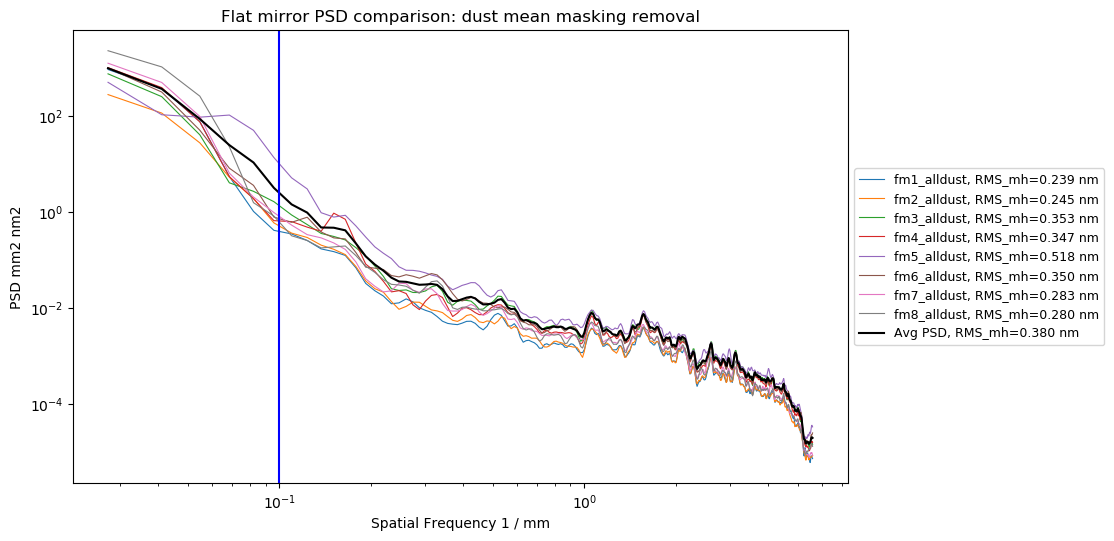

In [7]:
plt.figure(figsize=[10,6],dpi=100)
for obj in dust_psd:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, linewidth=0.8, label='{0}, RMS_mh={1:.3f}'.format(obj.surf_name, obj.rms_mh))
plt.loglog(avg_k_radial.value, avg_psd_radial.value, 'k', label='Avg PSD, RMS_mh={0:.3f}'.format(avg_rms_mh))
plt.xlabel('Spatial Frequency {0}'.format(obj.k_radial.unit))
plt.ylabel('PSD {0}'.format(obj.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust mean masking removal')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(prop={'size':9})
plt.axvline(x=0.1, color='b')

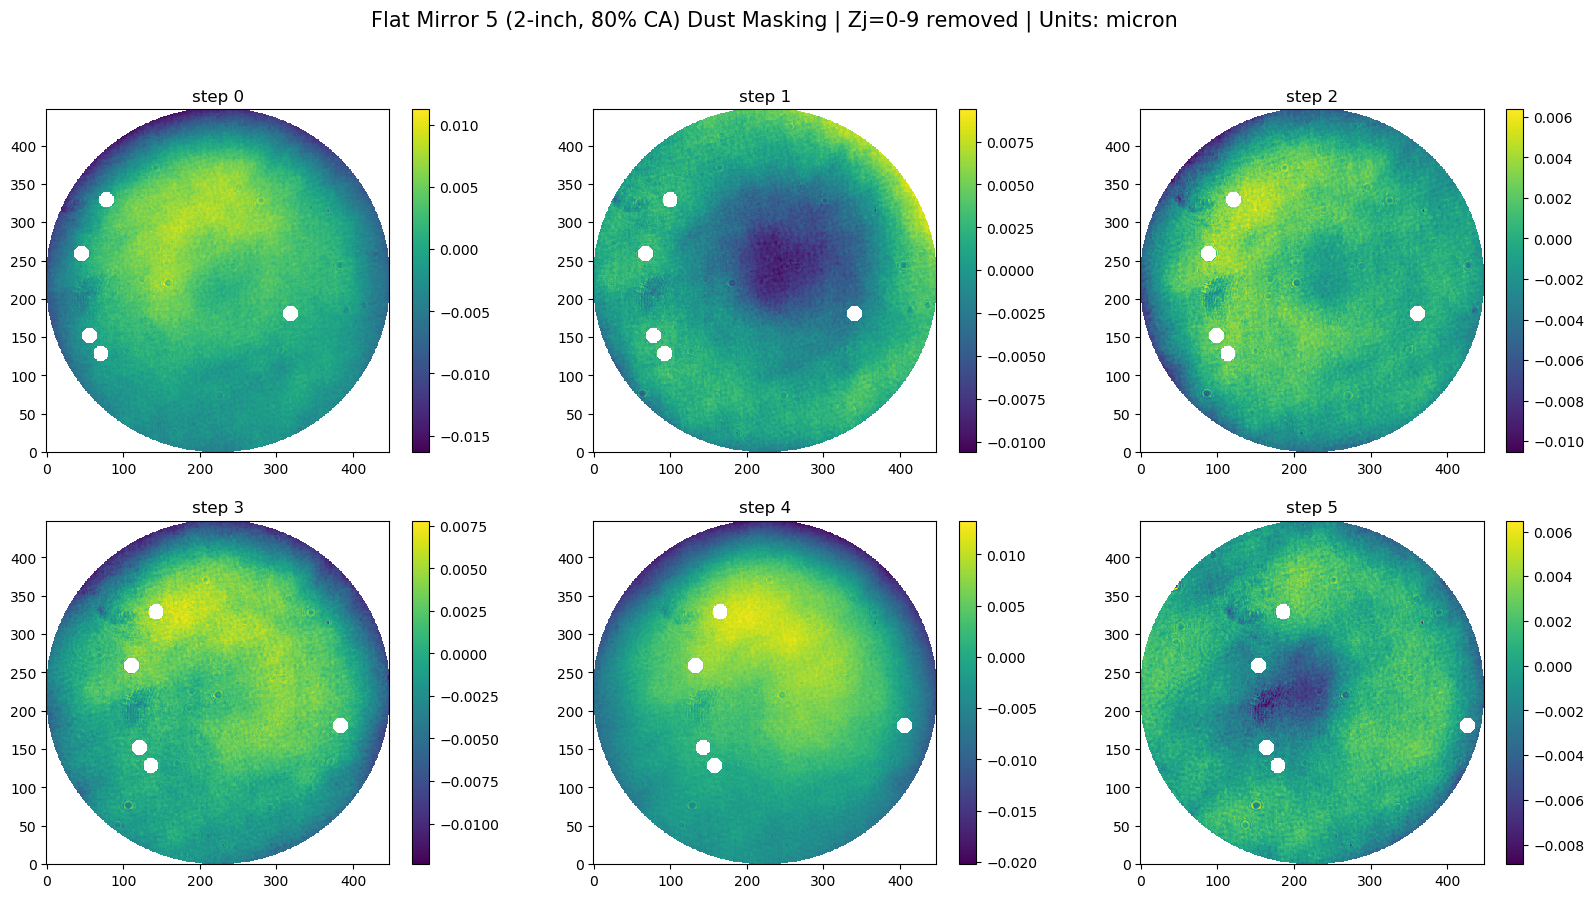

In [9]:
opt_num = 4
plt.figure(figsize=[20, 10], dpi=100)
plt.suptitle('Flat Mirror {0} (2-inch, {1}% CA) Dust Masking | Zj=0-9 removed | Units: {2}'.format(opt_num+1, opt_parms['ca'], opt_parms['surf_units']), fontsize=15)
for nstep in range(0,tot_step):  
    order = '23{0}'.format(nstep+1)
    plt.subplot(order)
    plt.imshow(dfx.sn_map(dust_all_set[opt_num].flat_data_mask[nstep].reshape(mask.shape),mask), origin='lower')#, vmin=vmin, vmax=vmax)
    plt.title('step {0}'.format(nstep))
    plt.colorbar()

In [5]:
%%time
# build dust maps
dust_all_set = []
dust_psd = [] # objects list: [flat mirror][dust number].objects
medbias_psd = []

for nf in range(0, len(fm_list)): # choose optic
    fm_num = fm_list[nf]
    
    # build all dust mask
    all_dust = np.ones((np.shape(dcen_x)[1], mask.shape[0], mask.shape[1]))
    for ns in range(0, np.shape(dcen_x)[1]): # per step
        mask_step = np.ones_like(mask).astype(float)
        for nd in range(0, np.shape(dcen_x)[0]): # build each dust location at the step
            dmc = np.zeros_like(mask)
            dm_coord = draw.circle(r=dcen_y[nd]+y_offset[nf], 
                                   c=dcen_x[nd][ns]+x_offset[nf],
                                   radius=dust_radius)
            dmc[dm_coord] = True
            mask_step[dmc==True] = np.nan
        all_dust[ns] = mask_step
    print('All dust masked for fm{0}'.format(fm_num))
    
    # use dust class to load in dust masks, calc median and mean
    dd = dust(name='fm{0}_dust_all'.format(fm_num))
    dd.load_mask(mask_set=all_dust)
    dd.apply_mask_data_flat(data_flat=surf_flat[nf]) # order: mirror number, step num, flat_data shape
    dd.calc_mean_mask()
    
    # calculate the PSDs
    # calculate PSD for all dust masked
    adp = psd.surfPSD(surf_name='fm{0}_alldust'.format(fm_num))
    adp.load_surf(data=dd.mean_surf*opt_parms['surf_units'], wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
    adp.load_mask(mask=mask)
    adp.calc_psd(oversamp = opt_parms['ovs'])
    adp.calc_psd_radial(ring_width=opt_parms['ring_width'])
    print('PSD and radial profile for all dust masked in fm{0} complete\n'.format(fm_num))
    
    # calculate the PSD for median bias surface
    '''
    dd.calc_median_bias(data_flat=surf_flat[nf])
    mbp = psd.surfPSD(surf_name='fm{0}_medbias'.format(fm_num))
    mbp.load_surf(data=dd.med_bias*opt_parms['surf_units'], wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
    mbp.load_mask(mask=mask)
    mbp.calc_psd(oversamp = opt_parms['ovs'])
    mbp.calc_psd_radial(ring_width=opt_parms['ring_width'])
    print('PSD and radial profile for median bias in fm{0} complete\n'.format(fm_num))
    '''
    
    # add objects to the lists
    #medbias_psd.append(mbp)
    dust_all_set.append(dd)
    dust_psd.append(adp)

All dust masked for fm1
PSD and radial profile for all dust masked in fm1 complete

All dust masked for fm2
PSD and radial profile for all dust masked in fm2 complete

All dust masked for fm3
PSD and radial profile for all dust masked in fm3 complete

All dust masked for fm4
PSD and radial profile for all dust masked in fm4 complete

All dust masked for fm5
PSD and radial profile for all dust masked in fm5 complete

All dust masked for fm6
PSD and radial profile for all dust masked in fm6 complete

All dust masked for fm7
PSD and radial profile for all dust masked in fm7 complete

All dust masked for fm8
PSD and radial profile for all dust masked in fm8 complete

CPU times: user 4min 42s, sys: 1min 34s, total: 6min 17s
Wall time: 6min 5s


In [6]:
# calculate the average PSD from the normalized set

# flatten the data from the normalized set
flat_norm = np.zeros((len(dust_psd), opt_parms['ovs']*opt_parms['ovs']))
flat_var = np.zeros((len(dust_psd)))
for n in range(0, len(dust_psd)):
    flat_norm[n] = dust_psd[n].psd_norm.reshape(opt_parms['ovs']*opt_parms['ovs'])
    flat_var[n] = dust_psd[n].var.value
#calculate the mean across the flat data
norm_psd_avg = np.mean(flat_norm, axis=0).reshape(opt_parms['ovs'], opt_parms['ovs'])*dust_psd[n].psd_norm.unit
# calibrate the average PSD
var_avg = np.mean(flat_var)*dust_psd[n].var.unit
cal_psd_avg = norm_psd_avg*var_avg
#create the radial psd profile by going through any open object
(avg_k_radial, avg_psd_radial) = dust_psd[n].do_psd_radial(ring_width=opt_parms['ring_width'],
                                                           psd_data = cal_psd_avg)
avg_rms_mh = dust_psd[n].calc_psd_rms(tgt_low=0.1/u.mm, tgt_high=dust_psd[n].k_max,
                                        pwr_opt=cal_psd_avg)

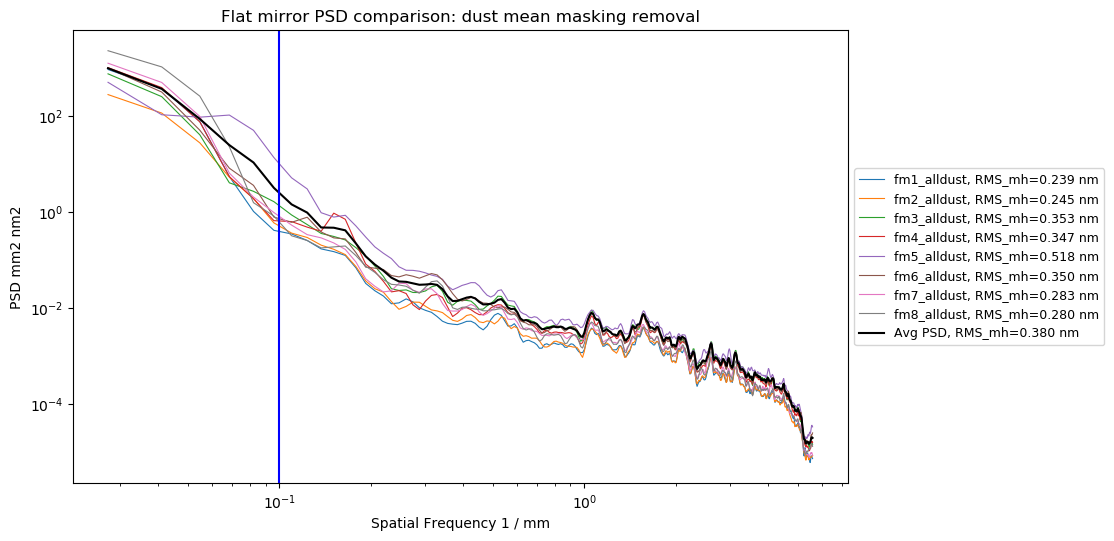

In [7]:
plt.figure(figsize=[10,6],dpi=100)
for obj in dust_psd:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, linewidth=0.8, label='{0}, RMS_mh={1:.3f}'.format(obj.surf_name, obj.rms_mh))
plt.loglog(avg_k_radial.value, avg_psd_radial.value, 'k', label='Avg PSD, RMS_mh={0:.3f}'.format(avg_rms_mh))
plt.xlabel('Spatial Frequency {0}'.format(obj.k_radial.unit))
plt.ylabel('PSD {0}'.format(obj.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust mean masking removal')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(prop={'size':9})
plt.axvline(x=0.1, color='b')

In [62]:
ss = psd.surfPSD(surf_name='fm8_step0')
ss.load_surf(data=surf_cube[7][0], wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
ss.load_mask(mask=mask)
ss.calc_psd(oversamp = opt_parms['ovs'])
ss.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(ss.surf_name))

PSD and radial profile for fm8_step0 complete


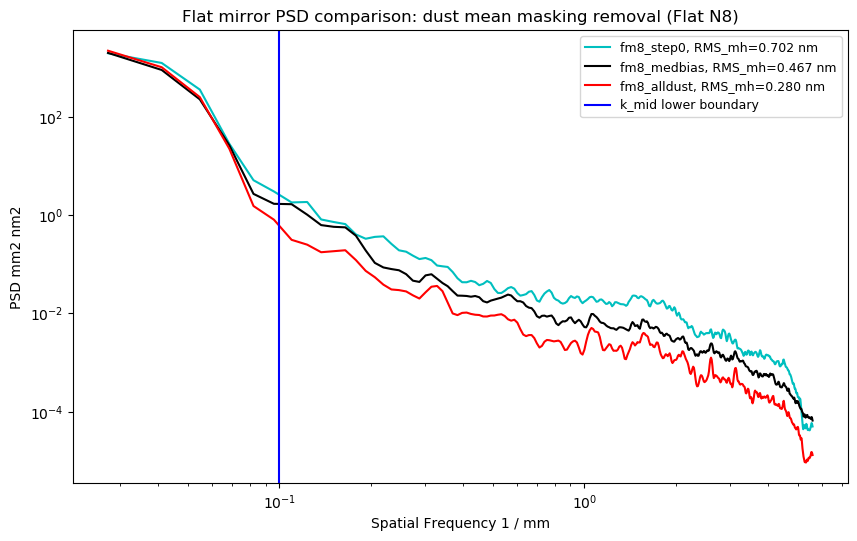

In [64]:
ifm=7
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(ss.k_radial.value, ss.psd_radial_cal.value, 'c', 
           label='{0}, RMS_mh={1:.3f}'.format(ss.surf_name, ss.rms_mh))
plt.loglog(medbias_psd[ifm].k_radial.value, medbias_psd[ifm].psd_radial_cal.value, 'k', 
           label='{0}, RMS_mh={1:.3f}'.format(medbias_psd[ifm].surf_name, medbias_psd[ifm].rms_mh))
plt.loglog(dust_psd[ifm].k_radial.value, dust_psd[ifm].psd_radial_cal.value, 'r', 
           label='{0}, RMS_mh={1:.3f}'.format(dust_psd[ifm].surf_name, dust_psd[ifm].rms_mh))
plt.axvline(x=0.1, color='b', label='k_mid lower boundary')
plt.xlabel('Spatial Frequency {0}'.format(obj.k_radial.unit))
plt.ylabel('PSD {0}'.format(obj.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust mean masking removal (Flat N{0})'.format(fm_list[ifm]))
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

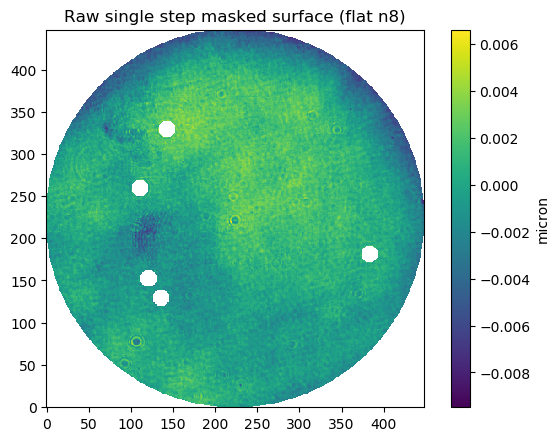

In [52]:
nstep = 3
nflat = 7
plt.figure(figsize=[7,5], dpi=100)
plt.imshow(dfx.sn_map(dust_all_set[nflat].flat_data_mask[nstep].reshape(mask.shape),mask),origin='lower') 
plt.title('Raw single step masked surface (flat n{0})'.format(fm_list[nflat]))
plt.colorbar().set_label(opt_parms['surf_units'])

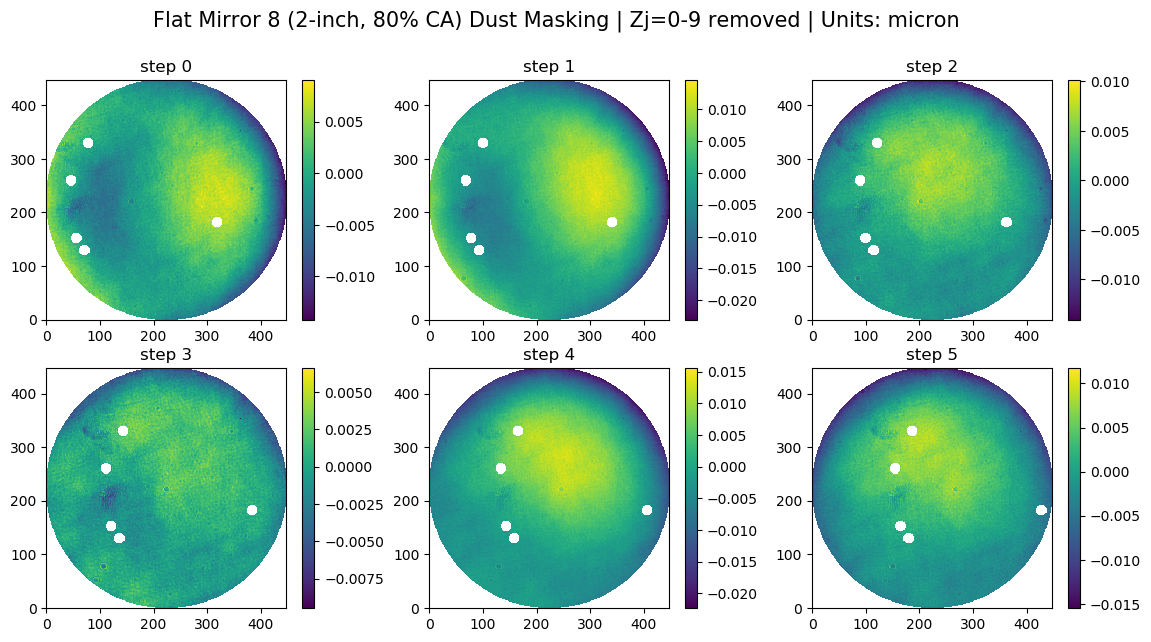

In [58]:
plt.figure(figsize=[14, 7], dpi=100)
plt.suptitle('Flat Mirror 8 (2-inch, {0}% CA) Dust Masking | Zj=0-9 removed | Units: {1}'.format(opt_parms['ca'], opt_parms['surf_units']), fontsize=15)
for nstep in range(0,tot_step):  
    order = '23{0}'.format(nstep+1)
    plt.subplot(order)
    plt.imshow(dfx.sn_map(dust_all_set[nflat].flat_data_mask[nstep].reshape(mask.shape),mask), origin='lower')#, vmin=vmin, vmax=vmax)
    plt.title('step {0}'.format(nstep))
    plt.colorbar()

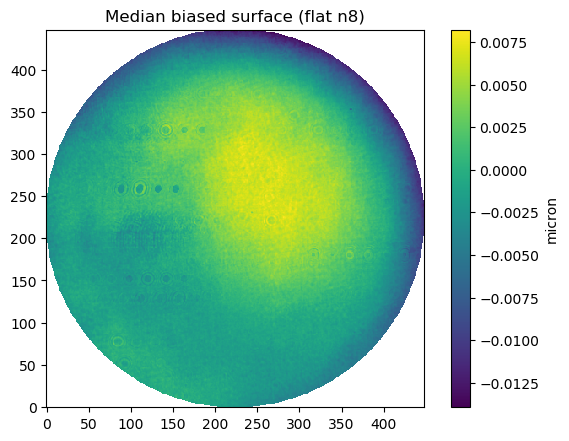

In [44]:
nstep = 0
nflat = 7
plt.figure(figsize=[7,5], dpi=100)
plt.imshow(dfx.sn_map(dust_all_set[nflat].med_bias,mask),origin='lower') 
plt.title('Median biased surface (flat n{0})'.format(fm_list[nflat]))
plt.colorbar().set_label(opt_parms['surf_units'])

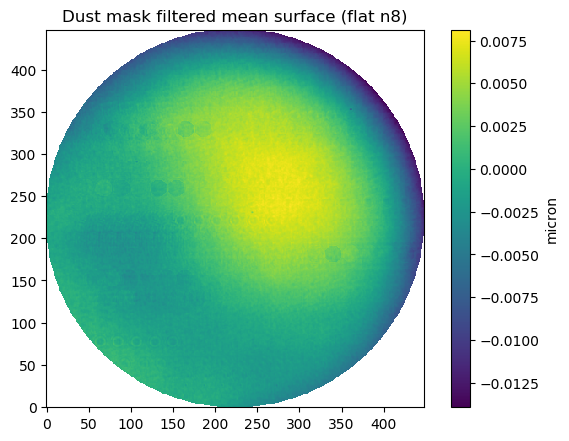

In [59]:
nstep = 0
nflat = 7
plt.figure(figsize=[7,5], dpi=100)
plt.imshow(dfx.sn_map(dust_all_set[nflat].mean_surf,mask),origin='lower') 
plt.title('Dust mask filtered mean surface (flat n{0})'.format(fm_list[nflat]))
plt.colorbar().set_label(opt_parms['surf_units'])

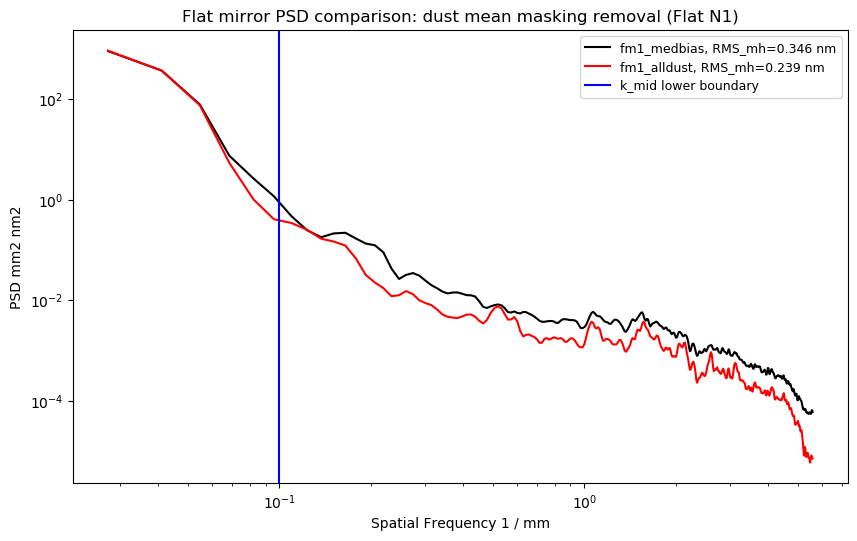

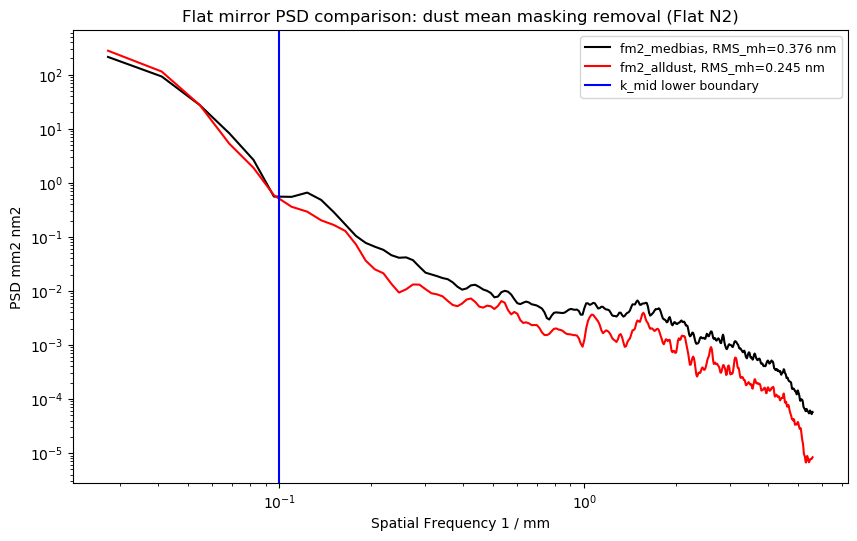

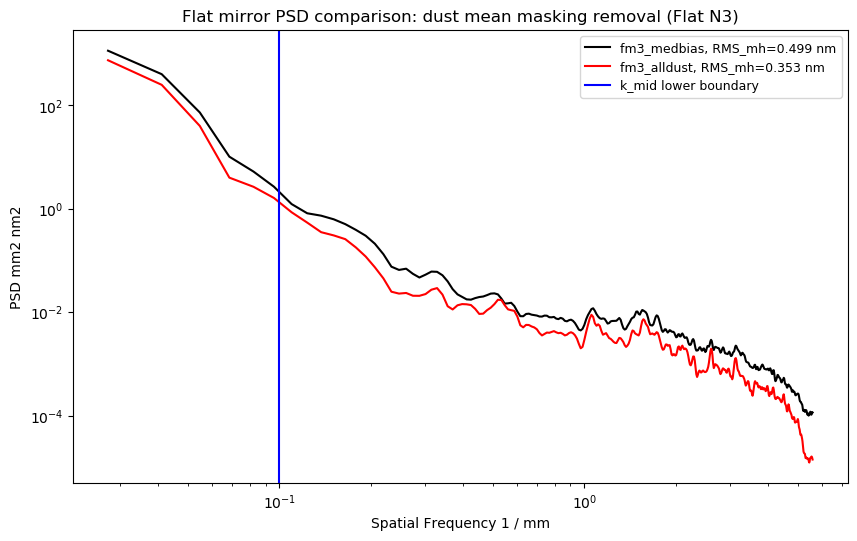

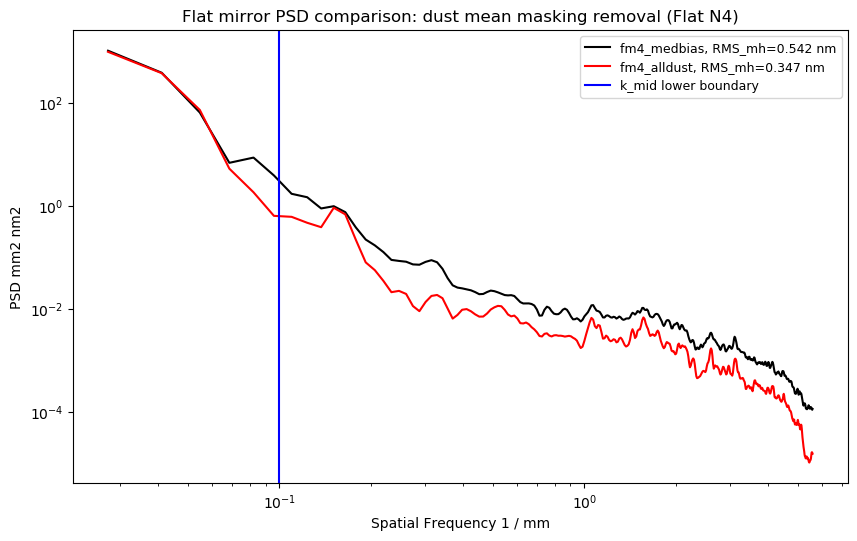

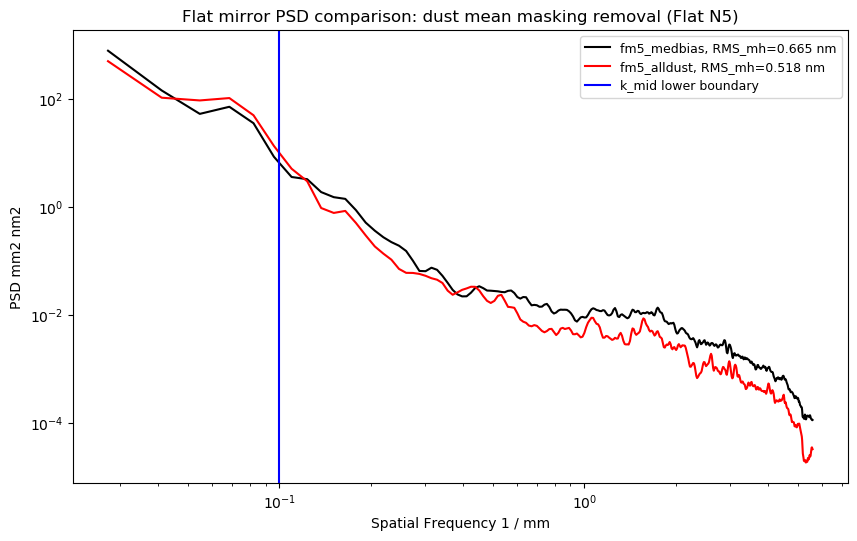

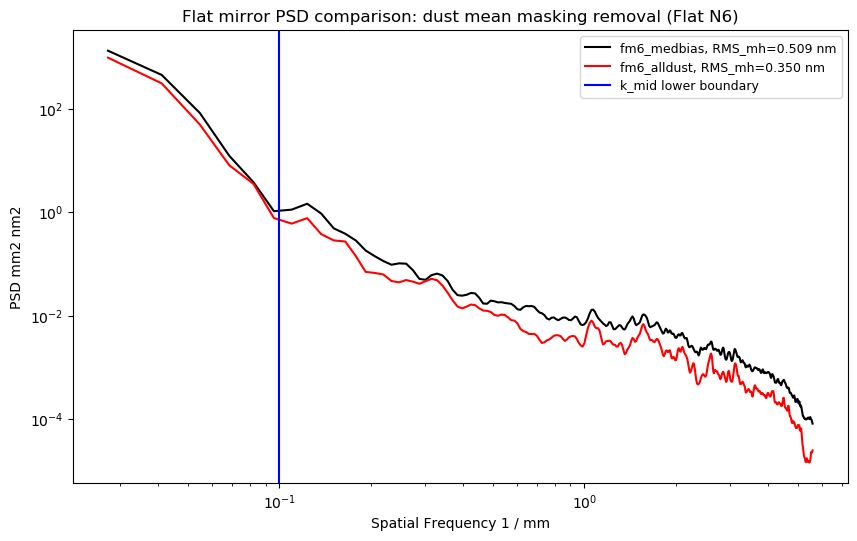

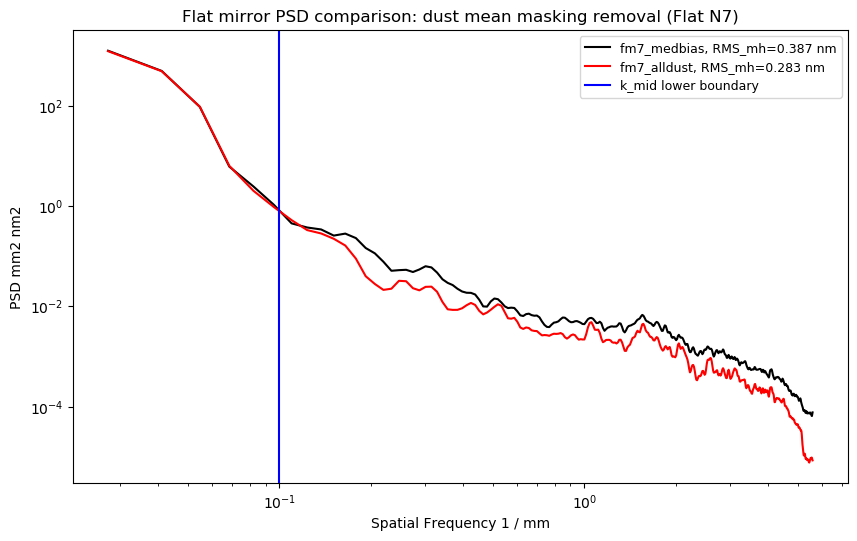

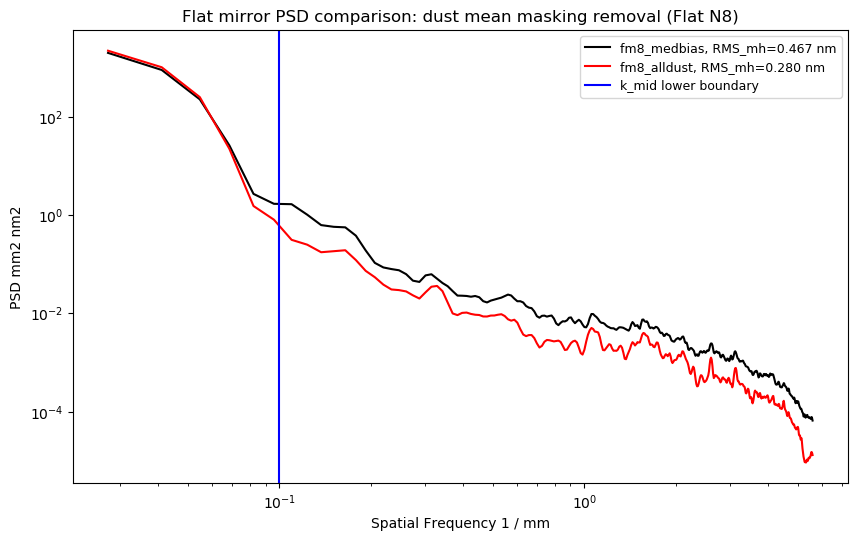

In [8]:
#ifm = 0
for ifm in range(0, len(fm_list)):
    plt.figure(figsize=[10,6],dpi=100)
    plt.loglog(medbias_psd[ifm].k_radial.value, medbias_psd[ifm].psd_radial_cal.value, 'k', 
               label='{0}, RMS_mh={1:.3f}'.format(medbias_psd[ifm].surf_name, medbias_psd[ifm].rms_mh))
    plt.loglog(dust_psd[ifm].k_radial.value, dust_psd[ifm].psd_radial_cal.value, 'r', 
               label='{0}, RMS_mh={1:.3f}'.format(dust_psd[ifm].surf_name, dust_psd[ifm].rms_mh))
    plt.axvline(x=0.1, color='b', label='k_mid lower boundary')
    plt.xlabel('Spatial Frequency {0}'.format(dust_psd[ifm].k_radial.unit))
    plt.ylabel('PSD {0}'.format(dust_psd[ifm].psd_radial_cal.unit))
    plt.title('Flat mirror PSD comparison: dust mean masking removal (Flat N{0})'.format(fm_list[ifm]))
    #plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(prop={'size':9})

In [42]:
# DO NOT DELETE - code for running individual dust testing

# build dust maps
dust_set= []
dust_all_psd = []
dust_psd = [] # objects list: [flat mirror][dust number].objects
medbias_psd = []

fm_list_select = [2, 5, 8] # specific optics to look at

for nf in range(0, len(fm_list)): # choose optic
    fm_num = fm_list[nf]
    # initialize holder lists
    ds_hold= []
    dpsd_hold = []
    if fm_num in fm_list_select: # do 3 specific ones instead of all 8
        for nd in range(0, np.shape(dcen_x)[0]): # choose dust particle
            dd = dust(name='fm{0}_dust{1}'.format(fm_num, nd))
            # set_mask handles all the steps at once, skipping another for loop here
            dd.set_mask(size=mask.shape[0], 
                    x_loc=[x+x_offset[nf] for x in dcen_x[nd]], 
                    y_loc=(dcen_y[nd]+y_offset[nf]), 
                    rad=drad[nd])
            dd.apply_mask_data_flat(data_flat=surf_flat[nf]) # order: mirror num, step num, flat_data shape
            dd.calc_mean_mask()
            print('Dust mask applied for {0}'.format(dd.name))
            ds_hold.append(dd)

            # calculate the PSD for the dust
            dpsd = psd.surfPSD(surf_name = dd.name)
            dpsd.load_surf(data=dd.mean_surf*opt_parms['surf_units'], wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
            dpsd.load_mask(mask=mask)
            dpsd.calc_psd(oversamp = opt_parms['ovs'])
            dpsd.calc_psd_radial(ring_width=opt_parms['ring_width'])
            dpsd_hold.append(dpsd)
            print('PSD and radial profile for dust {0} complete'.format(dpsd.surf_name))
        # out of dust particle loop
        
        # calculate the all-dust mask
        all_dust_mask = np.zeros((np.shape(ds_hold[0].mask)))
        for ns in range(0, np.shape(dcen_x)[1]): # calculate all dust per step
            msk_hold = ds_hold[0].mask[ns]
            for nd in range(1, np.shape(dcen_x)[0]): # choose dust
                msk_hold = msk_hold * ds_hold[nd].mask[ns] # step through all dust at same step
            all_dust_mask[ns] = msk_hold
        dall = dust(name='fm{0}_dust_all'.format(fm_num))
        dall.load_mask(mask_set=all_dust_mask)
        dall.apply_mask_data_flat(data_flat=surf_flat[nf])
        dall.calc_mean_mask()
        print('All dust masks applied for fm{0}'.format(fm_num))
        adp = psd.surfPSD(surf_name='fm{0}_alldust'.format(fm_num))
        adp.load_surf(data=dall.mean_surf*opt_parms['surf_units'], wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
        adp.load_mask(mask=mask)
        adp.calc_psd(oversamp = opt_parms['ovs'])
        adp.calc_psd_radial(ring_width=opt_parms['ring_width'])
        print('PSD and radial profile for all dust masked in fm{0} complete\n'.format(fm_num))
        
        # calculate the median bias PSD (they should all be the same for all dust particles)
        dd.calc_median_bias(data_flat=surf_flat[nf]) # this only calculates the median bias image, not the PSD
        print('Median bias surface (no dust masking) calculated for fm{0}'.format(fm_num))
        mbp = psd.surfPSD(surf_name='fm{0}_medbias'.format(fm_num))
        mbp.load_surf(data=dd.med_bias*opt_parms['surf_units'], wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
        mbp.load_mask(mask=mask)
        mbp.calc_psd(oversamp = opt_parms['ovs'])
        mbp.calc_psd_radial(ring_width=opt_parms['ring_width'])
        print('PSD and radial profile for median bias in fm{0} complete\n'.format(fm_num))
        
        # add objects to the lists
        dust_all_psd.append(adp)
        medbias_psd.append(mbp)
        dust_set.append(ds_hold)
        dust_psd.append(dpsd_hold)
    else:
        print('Skipping fm{0} for now\n'.format(fm_num))

Skipping fm1 for now

Dust mask applied for fm2_dust0
PSD and radial profile for dust fm2_dust0 complete
Dust mask applied for fm2_dust1
PSD and radial profile for dust fm2_dust1 complete
Dust mask applied for fm2_dust2
PSD and radial profile for dust fm2_dust2 complete
Dust mask applied for fm2_dust3
PSD and radial profile for dust fm2_dust3 complete
All dust masks applied for fm2
PSD and radial profile for all dust masked in fm2 complete

Median bias surface (no dust masking) calculated for fm2
PSD and radial profile for median bias in fm2 complete

Skipping fm3 for now

Skipping fm4 for now

Dust mask applied for fm5_dust0
PSD and radial profile for dust fm5_dust0 complete
Dust mask applied for fm5_dust1
PSD and radial profile for dust fm5_dust1 complete
Dust mask applied for fm5_dust2
PSD and radial profile for dust fm5_dust2 complete
Dust mask applied for fm5_dust3
PSD and radial profile for dust fm5_dust3 complete
All dust masks applied for fm5
PSD and radial profile for all dust

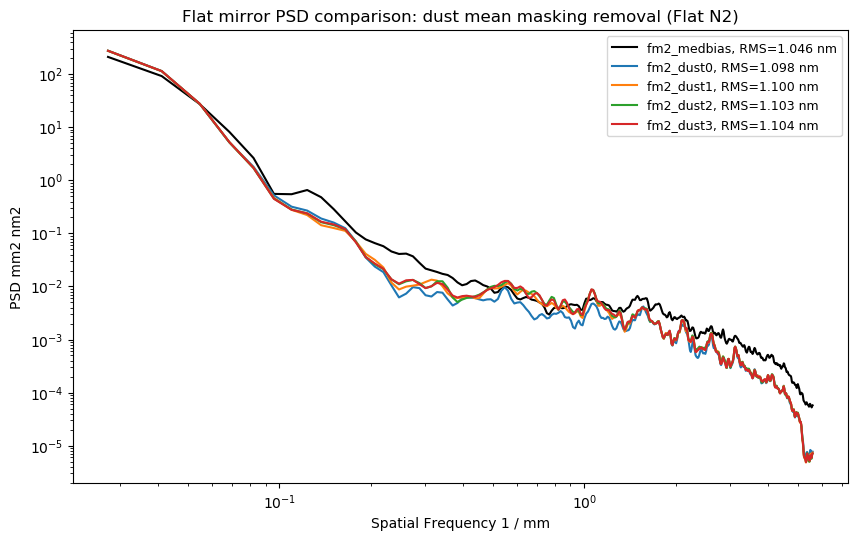

In [19]:
ifm = 0
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(medbias_psd[ifm].k_radial.value, medbias_psd[ifm].psd_radial_cal.value, 'k', 
           label='{0}, RMS={1:.3f}'.format(medbias_psd[ifm].surf_name, medbias_psd[ifm].rms))
for obj in dust_psd[ifm]:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, label='{0}, RMS={1:.3f}'.format(obj.surf_name, obj.rms))
plt.loglog(dust_all_psd[ifm].k_radial.value, dust_all_psd[ifm].psd_radial_cal.value, 'r', 
           label='{0}, RMS={1:.3f}'.format(dust_all_psd[ifm].surf_name, dust_all_psd[ifm].rms))
plt.xlabel('Spatial Frequency {0}'.format(obj.k_radial.unit))
plt.ylabel('PSD {0}'.format(obj.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust mean masking removal (Flat N{0})'.format(fm_list_select[ifm]))
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

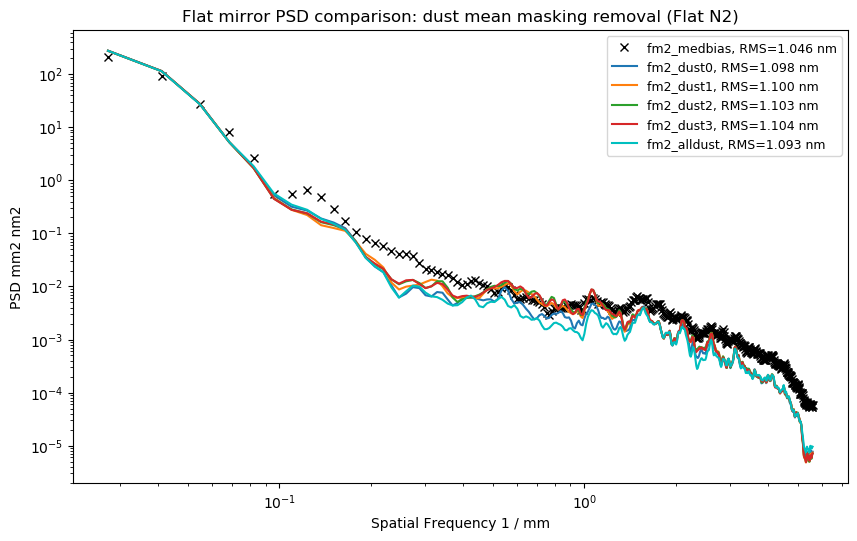

In [48]:
ifm = 0
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(medbias_psd[ifm].k_radial.value, medbias_psd[ifm].psd_radial_cal.value, 'xk', 
           label='{0}, RMS={1:.3f}'.format(medbias_psd[ifm].surf_name, medbias_psd[ifm].rms))
for obj in dust_psd[ifm]:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, label='{0}, RMS={1:.3f}'.format(obj.surf_name, obj.rms))
plt.loglog(dust_all_psd[ifm].k_radial.value, dust_all_psd[ifm].psd_radial_cal.value, 'c', 
           label='{0}, RMS={1:.3f}'.format(dust_all_psd[ifm].surf_name, dust_all_psd[ifm].rms))
plt.xlabel('Spatial Frequency {0}'.format(obj.k_radial.unit))
plt.ylabel('PSD {0}'.format(obj.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust mean masking removal (Flat N{0})'.format(fm_list_select[ifm]))
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

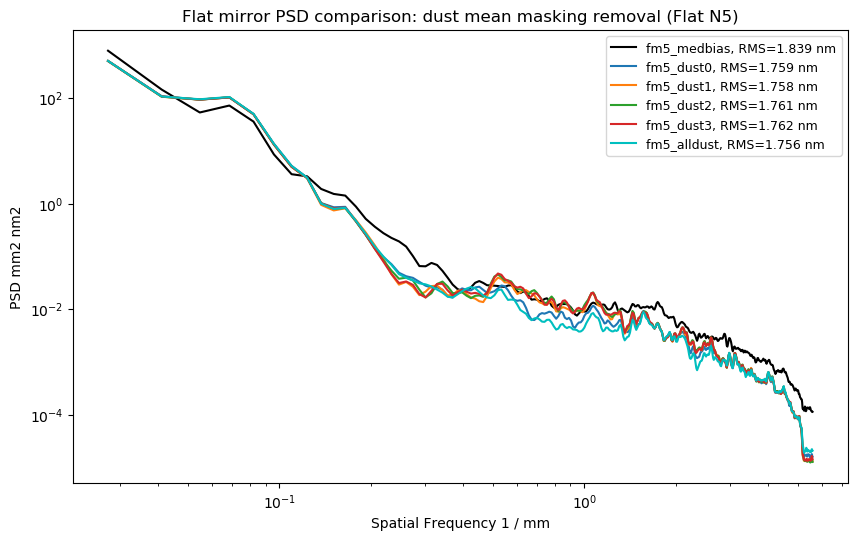

In [45]:
ifm = 1
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(medbias_psd[ifm].k_radial.value, medbias_psd[ifm].psd_radial_cal.value, 'k',
           label='{0}, RMS={1:.3f}'.format(medbias_psd[ifm].surf_name, medbias_psd[ifm].rms))
for obj in dust_psd[ifm]:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, label='{0}, RMS={1:.3f}'.format(obj.surf_name, obj.rms))
plt.loglog(dust_all_psd[ifm].k_radial.value, dust_all_psd[ifm].psd_radial_cal.value, 'c', 
           label='{0}, RMS={1:.3f}'.format(dust_all_psd[ifm].surf_name, dust_all_psd[ifm].rms))
plt.xlabel('Spatial Frequency {0}'.format(obj.k_radial.unit))
plt.ylabel('PSD {0}'.format(obj.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust mean masking removal (Flat N{0})'.format(fm_list_select[ifm]))
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

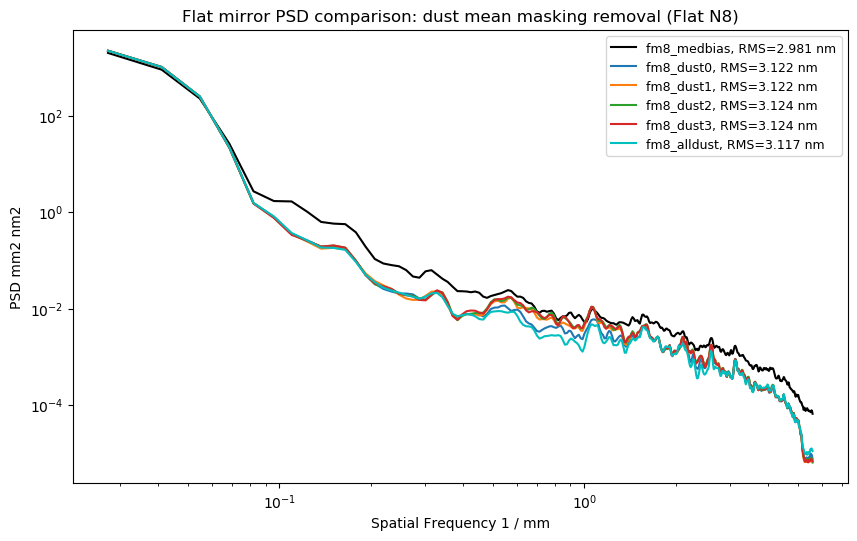

In [44]:
ifm = 2
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(medbias_psd[ifm].k_radial.value, medbias_psd[ifm].psd_radial_cal.value, 'k', 
           label='{0}, RMS={1:.3f}'.format(medbias_psd[ifm].surf_name, medbias_psd[ifm].rms))
for obj in dust_psd[ifm]:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, label='{0}, RMS={1:.3f}'.format(obj.surf_name, obj.rms))
plt.loglog(dust_all_psd[ifm].k_radial.value, dust_all_psd[ifm].psd_radial_cal.value, 'c', 
           label='{0}, RMS={1:.3f}'.format(dust_all_psd[ifm].surf_name, dust_all_psd[ifm].rms))
plt.xlabel('Spatial Frequency {0}'.format(obj.k_radial.unit))
plt.ylabel('PSD {0}'.format(obj.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust mean masking removal (Flat N{0})'.format(fm_list_select[ifm]))
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

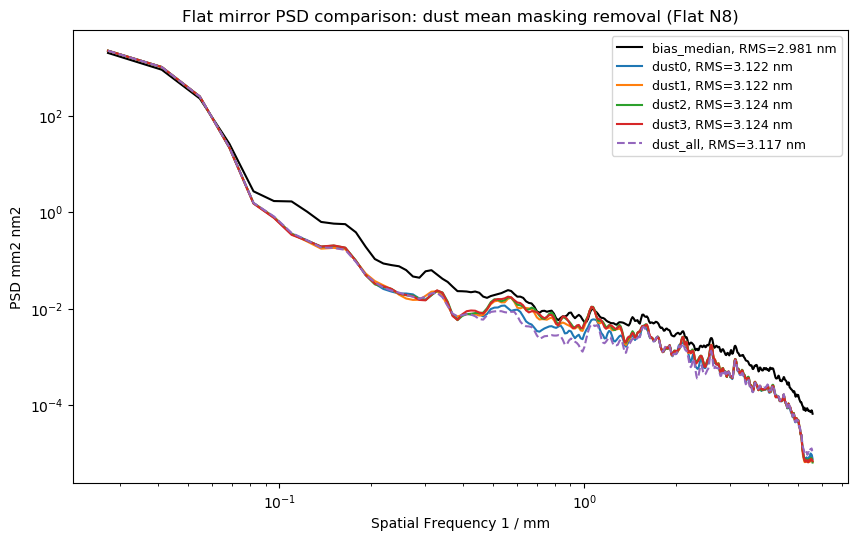

In [7]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(fm_bias.k_radial.value, fm_bias.psd_radial_cal.value, 'k', label='{0}, RMS={1:.3f}'.format(fm_bias.surf_name, fm_bias.rms))
for obj in dust_psd:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, label='{0}, RMS={1:.3f}'.format(obj.surf_name, obj.rms))
plt.loglog(dapsd.k_radial.value, dapsd.psd_radial_cal.value, '--', label='{0}, RMS={1:.3f}'.format(dapsd.surf_name, dapsd.rms))
plt.xlabel('Spatial Frequency {0}'.format(obj.k_radial.unit))
plt.ylabel('PSD {0}'.format(obj.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust mean masking removal (Flat N8)')
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

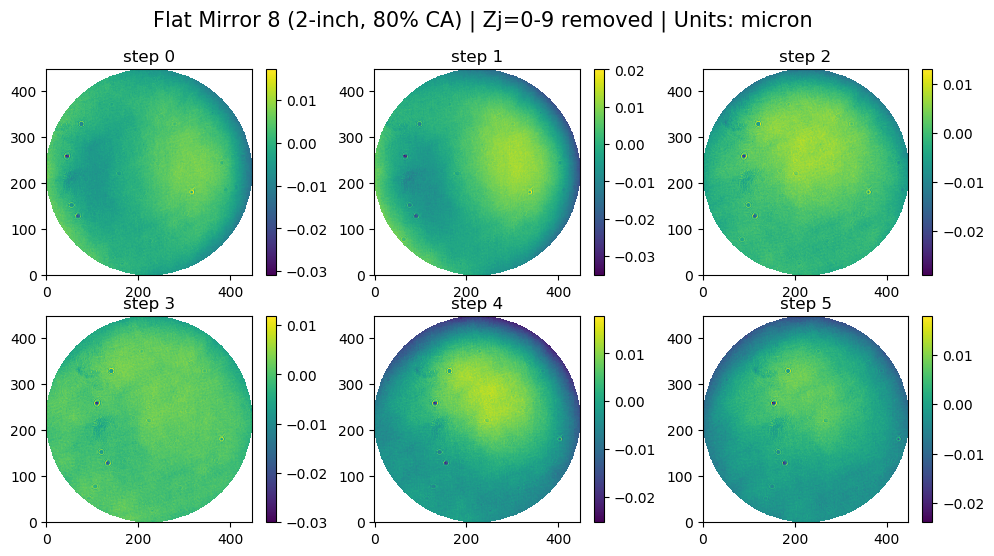

In [3]:
# calc min and max
#vmin = np.amin(data_set.value)
#vmax = np.amax(data_set.value)

plt.figure(figsize=[12, 6], dpi=100)
plt.suptitle('Flat Mirror 8 (2-inch, {0}% CA) | Zj=0-9 removed | Units: {1}'.format(opt_parms['ca'], data_set[0].unit), fontsize=15)
for n in range(0,tot_step):  
    order = '23{0}'.format(n+1)
    plt.subplot(order)
    plt.imshow(dfx.sn_map(data_set[n].value,mask), origin='lower')#, vmin=vmin, vmax=vmax)
    plt.title('step {0}'.format(n))
    plt.colorbar()

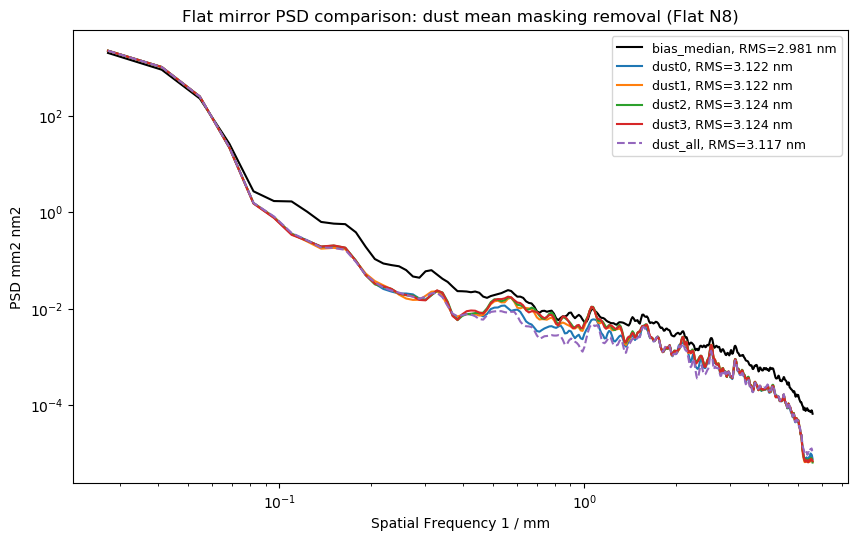

In [7]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(fm_bias.k_radial.value, fm_bias.psd_radial_cal.value, 'k', label='{0}, RMS={1:.3f}'.format(fm_bias.surf_name, fm_bias.rms))
for obj in dust_psd:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, label='{0}, RMS={1:.3f}'.format(obj.surf_name, obj.rms))
plt.loglog(dapsd.k_radial.value, dapsd.psd_radial_cal.value, '--', label='{0}, RMS={1:.3f}'.format(dapsd.surf_name, dapsd.rms))
plt.xlabel('Spatial Frequency {0}'.format(obj.k_radial.unit))
plt.ylabel('PSD {0}'.format(obj.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust mean masking removal (Flat N8)')
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

## Median calculation

In [3]:
# generate the median data
#med_data = np.median(flat_data, axis=0).reshape(np.shape(mask))
medfm_bias = np.zeros((np.product(np.shape(mask))))
for k in range(0, np.product(np.shape(mask))):
    pix_data = flat_data[:,k]
    pix_bin = pix_data[~np.isnan(pix_data)]
    medfm_bias[k] = np.median(pix_bin)
# reshape
medfm_bias = medfm_bias.reshape(np.shape(mask))*data_set.unit

# biased data
n_step = 'bias_median'
fm_bias = psd.surfPSD(surf_name = n_step)
fm_bias.load_surf(data=medfm_bias, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
fm_bias.load_mask(mask=mask)
fm_bias.calc_psd(oversamp = opt_parms['ovs'])
fm_bias.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(n_step))

# write the files - needs to be fixed
#file_bias = fits_folder+'flat_2in_ca{0}_n{1}_median_bias'.format(opt_parms['ca'], fm_num)
#dfx.write_fits(surface=medfm_bias, mask=mask, surf_parms=opt_parms, filename=file_bias)

PSD and radial profile for bias_median complete


Text(0.5, 1.0, 'Median data (micron)')

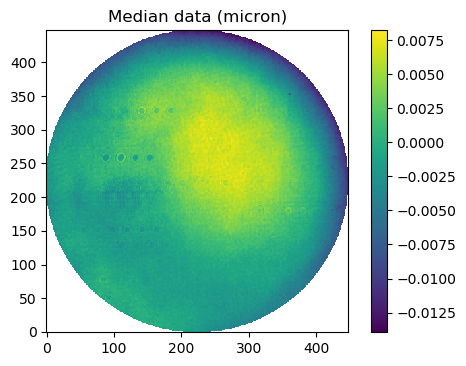

In [76]:
# show the plot of the median data
plt.figure(dpi=100)
plt.imshow(dfx.sn_map(medfm_bias.value,mask), origin='lower')
#plt.imshow(medfm_bias.value, origin='lower')
plt.colorbar()
plt.title('Median data ({0})'.format(data_set.unit))

## Single dust masking

In [5]:
dcen_x =([[46, 68,   89, 111, 133, 154],
          [71, 93,  114, 136, 158, 179],
          [56, 78,   99, 121, 143, 164],
          [78, 100, 121, 143, 165, 186]])
dcen_y= [259, 129, 152, 329]
drad=[8, 6, 5, 6]

# build dust maps
dust_set= []
dust_psd = []
for nd in range(0, np.shape(dcen_x)[0]): # iterating through specific dusts
    dd = dust(name='dust{0}'.format(nd))
    dd.mask(size=mask.shape[0], x_loc=dcen_x[nd], y_loc=dcen_y[nd], rad=drad[nd])
    dd.set_flat_data(data_cube=data_set)
    dd.calc_mean_surf()
    print('dust mask applied for {0}'.format(dd.name))
    dust_set.append(dd)
    
    # calculate the PSD stuff
    dpsd = psd.surfPSD(surf_name = 'dust{0}'.format(nd))
    dpsd.load_surf(data=dd.mean_surf*data_set.unit, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
    dpsd.load_mask(mask=mask)
    dpsd.calc_psd(oversamp = opt_parms['ovs'])
    dpsd.calc_psd_radial(ring_width=opt_parms['ring_width'])
    dust_psd.append(dpsd)
    print('PSD and radial profile for dust {0} complete'.format(dpsd.surf_name))
    
# apply to data

dust mask applied for dust0
PSD and radial profile for dust dust0 complete
dust mask applied for dust1
PSD and radial profile for dust dust1 complete
dust mask applied for dust2
PSD and radial profile for dust dust2 complete
dust mask applied for dust3
PSD and radial profile for dust dust3 complete


In [6]:
# build all dust
all_dust = np.ones((np.shape(dcen_x)[1], mask.shape[0], mask.shape[1]))
for ns in range(0, np.shape(dcen_x)[1]): # per step
    mask_step = np.ones_like(mask).astype(float)
    for nd in range(0, np.shape(dcen_x)[0]): # build each dust location at the step
        dmc = np.zeros_like(mask)
        dm_coord = draw.circle(r=dcen_y[nd], c=dcen_x[nd][ns], radius=drad[nd])
        dmc[dm_coord] = True
        mask_step[dmc==True] = np.nan
    all_dust[ns] = mask_step
# create the object and the PSD
dall = dust(name='dust_all')
dall.load_mask(mask_set=all_dust)
dall.set_flat_data(data_cube=data_set)
dall.calc_mean_surf()
dapsd = psd.surfPSD(surf_name='dust_all')
dapsd.load_surf(data=dall.mean_surf*data_set.unit, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
dapsd.load_mask(mask=mask)
dapsd.calc_psd(oversamp = opt_parms['ovs'])
dapsd.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(dapsd.surf_name))

PSD and radial profile for dust_all complete


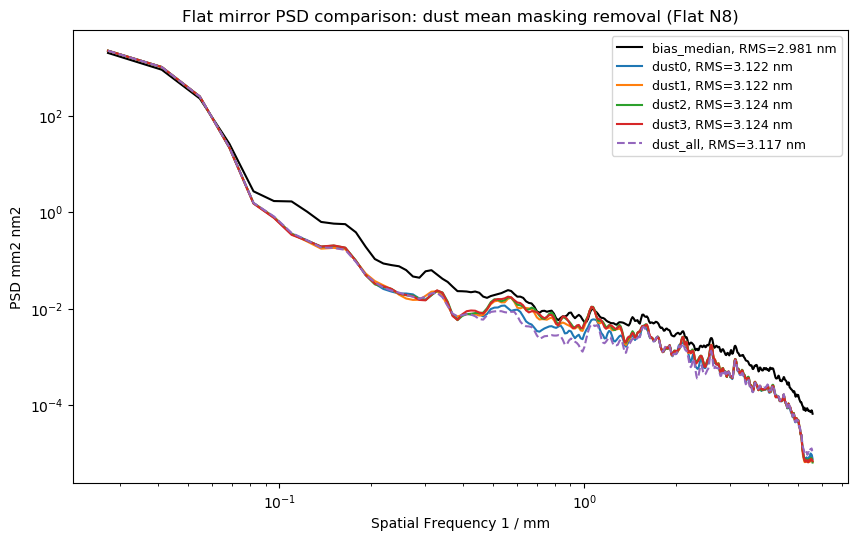

In [7]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(fm_bias.k_radial.value, fm_bias.psd_radial_cal.value, 'k', label='{0}, RMS={1:.3f}'.format(fm_bias.surf_name, fm_bias.rms))
for obj in dust_psd:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, label='{0}, RMS={1:.3f}'.format(obj.surf_name, obj.rms))
plt.loglog(dapsd.k_radial.value, dapsd.psd_radial_cal.value, '--', label='{0}, RMS={1:.3f}'.format(dapsd.surf_name, dapsd.rms))
plt.xlabel('Spatial Frequency {0}'.format(obj.k_radial.unit))
plt.ylabel('PSD {0}'.format(obj.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust mean masking removal (Flat N8)')
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

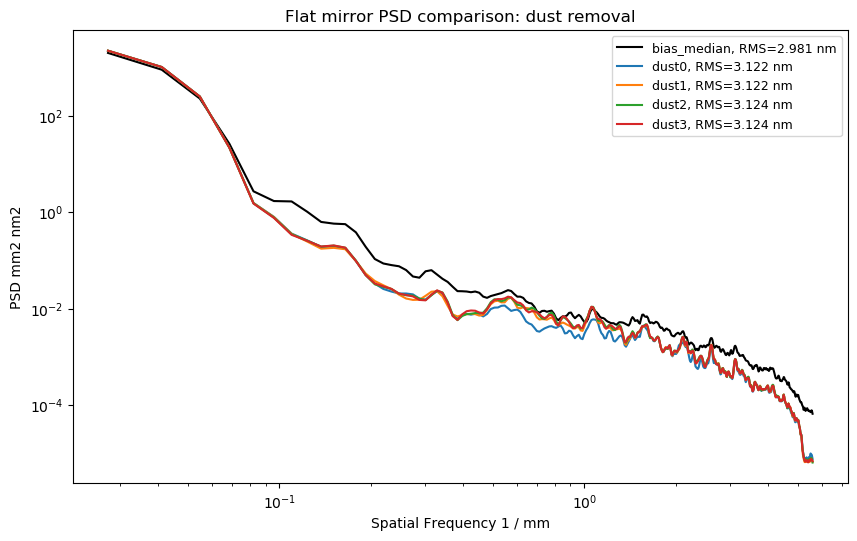

In [56]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(fm_bias.k_radial.value, fm_bias.psd_radial_cal.value, 'k', label='{0}, RMS={1:.3f}'.format(fm_bias.surf_name, fm_bias.rms))
for obj in dust_psd:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, label='{0}, RMS={1:.3f}'.format(obj.surf_name, obj.rms))
plt.xlabel('Spatial Frequency {0}'.format(obj.k_radial.unit))
plt.ylabel('PSD {0}'.format(obj.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust removal')
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

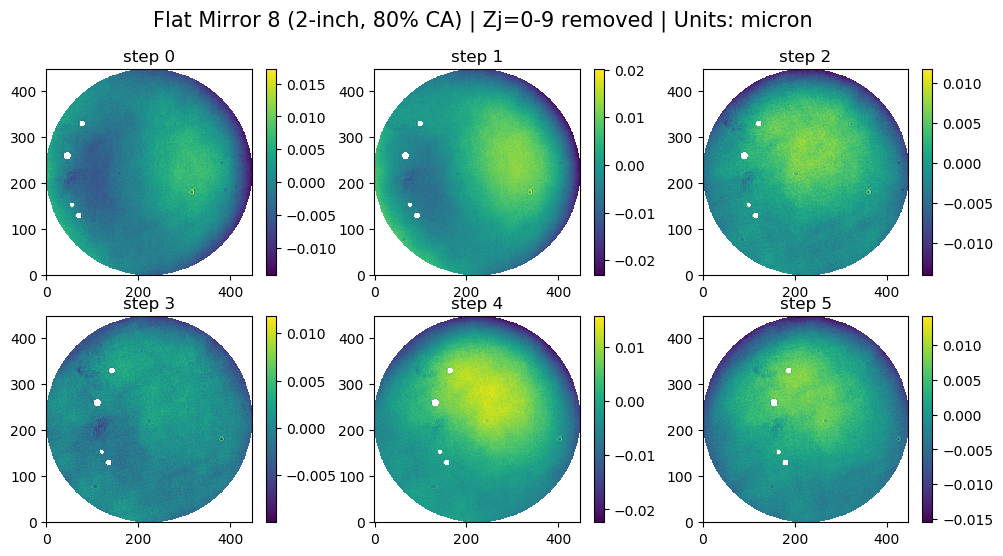

In [124]:
# plot dust mask maps
#vmin = np.amin(data_set.value)
#vmax = np.amax(data_set.value)

plt.figure(figsize=[12, 6], dpi=100)
plt.suptitle('Flat Mirror 8 (2-inch, {0}% CA) | Zj=0-9 removed | Units: {1}'.format(opt_parms['ca'], data_set[0].unit), fontsize=15)
for n in range(0,tot_step):  
    order = '23{0}'.format(n+1)
    plt.subplot(order)
    plt.imshow(dfx.sn_map(test_data[n].value,mask), origin='lower')#, vmin=vmin, vmax=vmax)
    plt.title('step {0}'.format(n))
    plt.colorbar()

In [125]:
# calculate the median and mean
medfm_mask1 = np.zeros((np.product(np.shape(mask))))
meanfm_mask1 = np.zeros_like(medfm_mask1)
for k in range(0, np.product(np.shape(mask))):
    pix_data = mask_flat_data[:,k]
    pix_bin = pix_data[~np.isnan(pix_data)]
    medfm_mask1[k] = np.median(pix_bin)
    meanfm_mask1[k] = np.mean(pix_bin)

# reshape    
medfm_mask1 = medfm_mask1.reshape(np.shape(mask))*data_set.unit
meanfm_mask1 = meanfm_mask1.reshape(np.shape(mask))*data_set.unit

# write the files - need to fix
#file_mask1 = fits_folder+'flat_2in_ca{0}_n{1}_median_1dustbias'.format(opt_parms['ca'], fm_num)
#dfx.write_fits(surface=medfm_mask1, mask=mask, surf_parms=sp, filename=file_mask1)

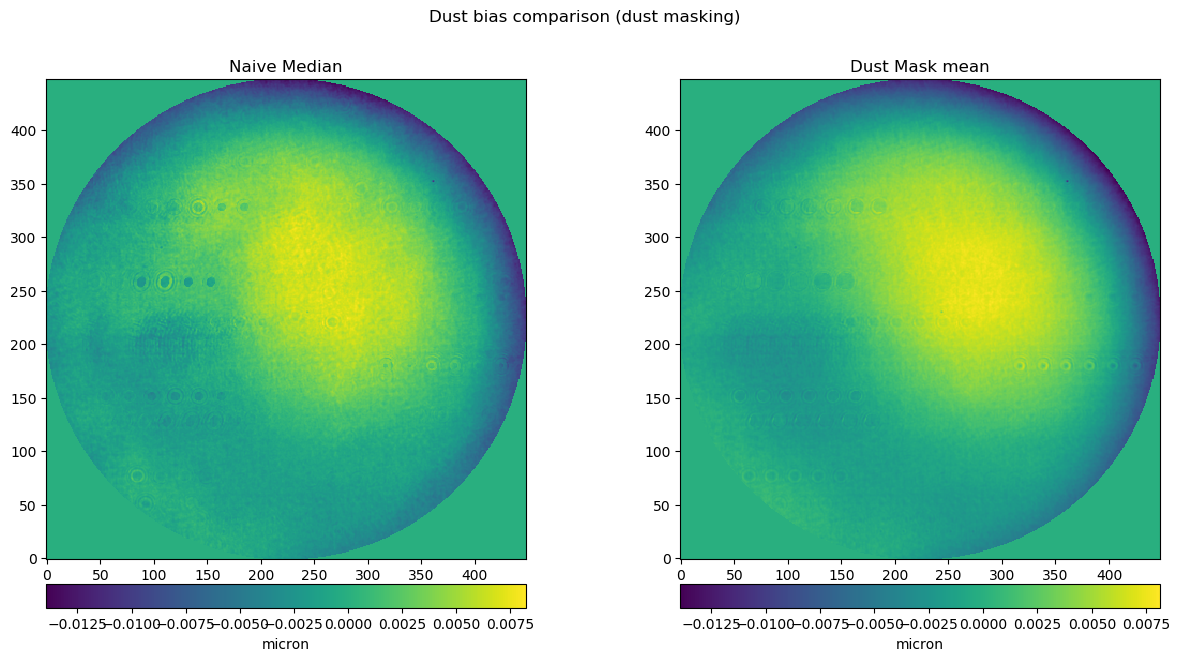

In [126]:
dfx.show2plots(supertitle='Dust bias comparison (dust masking)',
               data1 = medfm_bias,
               plot1_label='Naive Median',
               data2 = meanfm_mask1,
               plot2_label='Dust Mask mean',
               set_figsize=[15,7],
               set_dpi=100)

In [127]:
# 1 dust mask - mean
n_step = 'mask4dust_mean'
fm_mask3_mean = psd.surfPSD(surf_name = n_step)
fm_mask3_mean.load_surf(data=meanfm_mask1, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
fm_mask3_mean.load_mask(mask=mask)
fm_mask3_mean.calc_psd(oversamp = opt_parms['ovs'])
fm_mask3_mean.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(n_step))

PSD and radial profile for mask4dust_mean complete


In [86]:
# generate the PSDs

# biased data
n_step = 'bias_median'
fm_bias = psd.surfPSD(surf_name = n_step)
fm_bias.load_surf(data=medfm_bias, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
fm_bias.load_mask(mask=mask)
fm_bias.calc_psd(oversamp = opt_parms['ovs'])
fm_bias.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(n_step))

# 1 dust mask - median
n_step = 'mask1dust_median'
fm_mask1 = psd.surfPSD(surf_name = n_step)
fm_mask1.load_surf(data=medfm_mask1, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
fm_mask1.load_mask(mask=mask)
fm_mask1.calc_psd(oversamp = opt_parms['ovs'])
fm_mask1.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(n_step))

# 1 dust mask - mean
n_step = 'mask1dust_mean'
fm_mask1_mean = psd.surfPSD(surf_name = n_step)
fm_mask1_mean.load_surf(data=meanfm_mask1, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
fm_mask1_mean.load_mask(mask=mask)
fm_mask1_mean.calc_psd(oversamp = opt_parms['ovs'])
fm_mask1_mean.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(n_step))

PSD and radial profile for bias_median complete
PSD and radial profile for mask1dust_median complete
PSD and radial profile for mask1dust_mean complete


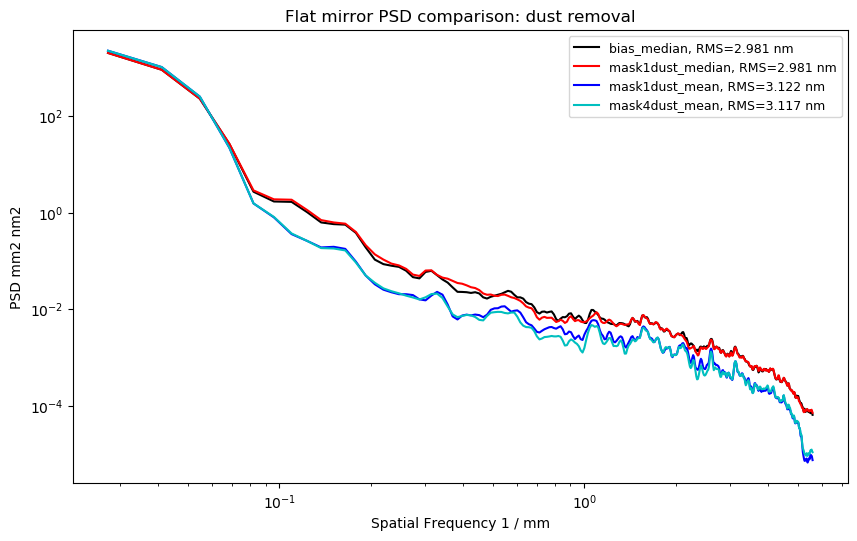

In [128]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(fm_bias.k_radial.value, fm_bias.psd_radial_cal.value, 'k', label='{0}, RMS={1:.3f}'.format(fm_bias.surf_name, fm_bias.rms))
plt.loglog(fm_mask1.k_radial.value, fm_mask1.psd_radial_cal.value, 'r', label='{0}, RMS={1:.3f}'.format(fm_mask1.surf_name, fm_mask1.rms))
plt.loglog(fm_mask1_mean.k_radial.value, fm_mask1_mean.psd_radial_cal.value, 'b', 
           label='{0}, RMS={1:.3f}'.format(fm_mask1_mean.surf_name, fm_mask1_mean.rms))
plt.loglog(fm_mask3_mean.k_radial.value, fm_mask3_mean.psd_radial_cal.value, 'c', 
           label='{0}, RMS={1:.3f}'.format(fm_mask3_mean.surf_name, fm_mask3_mean.rms))
plt.xlabel('Spatial Frequency {0}'.format(fm_bias.k_radial.unit))
plt.ylabel('PSD {0}'.format(fm_bias.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust removal')
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

## Pixel Filtering
AKA sigma clipping, because we're cutting off at 1 sigma (standard deviation)

Text(0.5, 1.0, 'Dust pixel testing')

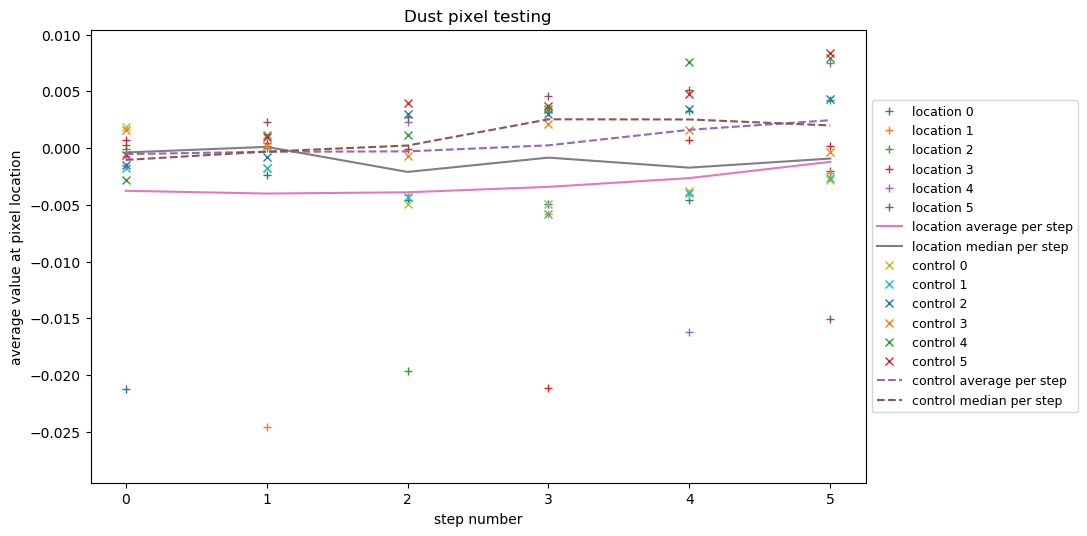

In [89]:
ddust = np.zeros((tot_step, tot_step))
ctrl = np.zeros((tot_step, tot_step))

ctrl_avg = np.zeros(tot_step)
ddust_avg = np.zeros(tot_step)
ctrl_med = np.zeros(tot_step)
ddust_med = np.zeros(tot_step)

for n in range(0, len(dust_center)):
    for m in range(0, tot_step):
        ddust[m][n] = data_set[m][dust_center[n][1]][dust_center[n][0]].value
        ctrl[m][n] = data_set[m][dust_center[n][1]+10][dust_center[n][0]].value
    ctrl_bin = ctrl[:,n]
    ddust_bin = ddust[:,n]
    ctrl_avg[n] = np.mean(ctrl_bin)
    ddust_avg[n] = np.mean(ddust_bin)
    ctrl_med[n] = np.median(ctrl_bin)
    ddust_med[n] = np.median(ddust_bin)

# plot the data
n_step = np.linspace(0, tot_step,tot_step, endpoint=False)
plt.figure(figsize=[10,6], dpi=100)
for n in range(0, tot_step):
    plt.plot(n_step, ddust[n], '+', label='location {0}'.format(n))
plt.plot(n_step, ddust_avg, label='location average per step')
plt.plot(n_step, ddust_med, label='location median per step')
for n in range(0, tot_step):
    plt.plot(n_step, ctrl[n], 'x', label='control {0}'.format(n))
plt.plot(n_step, ctrl_avg, '--', label='control average per step')
plt.plot(n_step, ctrl_med, '--', label='control median per step')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([np.amin([np.amin(ddust), np.amin(ddust)])*1.2, 
          np.amax([np.amax(ddust), np.amax(ctrl)])*1.25])
plt.xlabel('step number')
plt.ylabel('average value at pixel location')
plt.title('Dust pixel testing')

In [90]:
avg_surf_flat = np.zeros(np.product(np.shape(mask)))
med_surf_flat = np.zeros(np.product(np.shape(mask)))
for n in range(0, np.product(np.shape(mask))):
    x = flat_data[:,n]
    # set parameters
    rmax = np.mean(x) + (1*np.std(x))
    rmin = np.mean(x) - (1*np.std(x))
    out_ind = []
    for m in range(0, tot_step): # filter
        if x[m] < rmin or x[m] > rmax: # if outlier
            #x[m] = np.nan
            out_ind.append(m)
    if len(out_ind) != 0: # if outlier exists
        x = np.delete(x, out_ind)
    # take average and median of data
    avg_surf_flat[n] = np.mean(x)
    med_surf_flat[n] = np.median(x)
# reshape the matricies back
medfm_pix_med = np.reshape(med_surf_flat, np.shape(mask))*data_set.unit
medfm_pix_avg = np.reshape(avg_surf_flat, np.shape(mask))*data_set.unit

# write the files
#file_nobias_pix = fits_folder+'flat_2in_ca{0}_n{1}_median_pixbias'.format(ca_resize, fm_num)
#dfx.write_fits(surface=pix_med, mask=mask, surf_parms=sp, filename=file_nobias_pix)

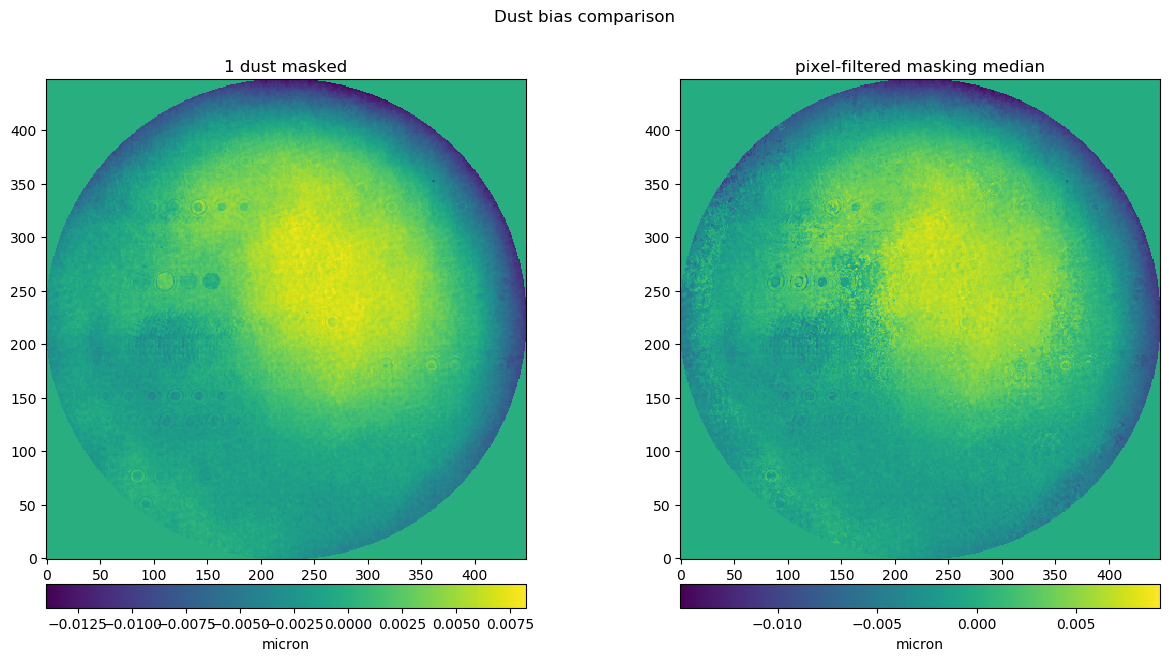

In [54]:
dfx.show2plots(supertitle='Dust bias comparison',
               data1 = medfm_mask1,
               plot1_label='1 dust masked',
               data2 = medfm_pix_med,
               plot2_label='pixel-filtered masking median',
               set_figsize=[15,7],
               set_dpi=100)

In [91]:
# Pixel Filtering PSD
n_step = 'pix_filter_med'
fm_pixfilter = psd.surfPSD(surf_name = n_step)
fm_pixfilter.load_surf(data=medfm_pix_med, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
fm_pixfilter.load_mask(mask=mask)
fm_pixfilter.calc_psd(oversamp = opt_parms['ovs'])
fm_pixfilter.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(n_step))

# Pixel Filtering PSD
n_step = 'pix_filter_avg'
fm_pixfilter_avg = psd.surfPSD(surf_name = n_step)
fm_pixfilter_avg.load_surf(data=medfm_pix_avg, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
fm_pixfilter_avg.load_mask(mask=mask)
fm_pixfilter_avg.calc_psd(oversamp = opt_parms['ovs'])
fm_pixfilter_avg.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete'.format(n_step))

PSD and radial profile for pix_filter_med complete
PSD and radial profile for pix_filter_avg complete


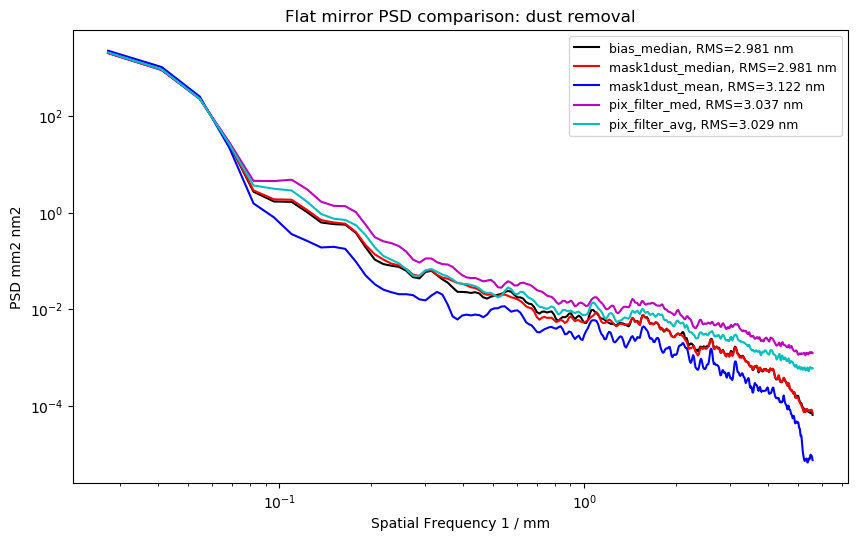

In [93]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(fm_bias.k_radial.value, fm_bias.psd_radial_cal.value, 'k',
           label='{0}, RMS={1:.3f}'.format(fm_bias.surf_name, fm_bias.rms))
plt.loglog(fm_mask1.k_radial.value, fm_mask1.psd_radial_cal.value, 'r', 
           label='{0}, RMS={1:.3f}'.format(fm_mask1.surf_name, fm_mask1.rms))
plt.loglog(fm_mask1_mean.k_radial.value, fm_mask1_mean.psd_radial_cal.value, 'b', 
           label='{0}, RMS={1:.3f}'.format(fm_mask1_mean.surf_name, fm_mask1_mean.rms))
plt.loglog(fm_pixfilter.k_radial.value, fm_pixfilter.psd_radial_cal.value, 'm', 
           label='{0}, RMS={1:.3f}'.format(fm_pixfilter.surf_name, fm_pixfilter.rms))
plt.loglog(fm_pixfilter_avg.k_radial.value, fm_pixfilter_avg.psd_radial_cal.value, 'c', 
           label='{0}, RMS={1:.3f}'.format(fm_pixfilter_avg.surf_name, fm_pixfilter_avg.rms))
plt.xlabel('Spatial Frequency {0}'.format(fm_bias.k_radial.unit))
plt.ylabel('PSD {0}'.format(fm_bias.psd_radial_cal.unit))
plt.title('Flat mirror PSD comparison: dust removal')
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})